<a href="https://colab.research.google.com/github/radhika3131/Deep_Learning_Projects/blob/main/Cat_dog_classificationipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloading the data**

Now upload the kaggle.json file

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"radhikaramsen","key":"93cb62c99c340787605f80117247ce36"}'}

Install kaggle API client

In [ ]:
!pip install kaggle

kaggle API client expects the file to be in ~/.kaggle

so move it there

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

we need to set permissions

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

list all available datasets

In [ ]:
!kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          37547       1056  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                               6KB  2023-05-28 18:26:48           5943        157  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           7680        161  1.0              
mohithsairamreddy/salary-data 

download the dataset

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:20<00:00, 45.4MB/s]
100% 812M/812M [00:20<00:00, 41.3MB/s]


If your file is a zip file you can unzip with the following code

In [ ]:
!unzip -qq /content/dogs-vs-cats.zip


In [ ]:
!unzip -qq /content/train.zip

After downloading the data we will uncompress it , we will create a new dataset containing three subsets:
1. training set with 1000 samples from each class(cat and dog)
2. validation set with 500 samples from each class
3. test set with 1000 sample from each class

**Copying images to training , validation and test dataset**

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("/content/train")
new_base_dir = pathlib.Path("cats_vs_dogs_smalldataset")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

#Building the model

we are dealing with bigger images and a more complex problem , we will make our model more larger ;It will have two more Conv2D and Maxpooling2D stages.This further reduces the size of the feature map so they are not overly large when we reach the *Flatten Layer*.

Note:
The depth of the feature maps progressively increases in the model (from 32 to 255) and the size of the feature map decreases(from 80*80 to 7*7)

**Instantiating a small convnet for dogs vs. cats classification**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3)) #The model expect RGB images of size 180*180
x = layers.Rescaling(1./255)(inputs) # rescale input to [0,1] range by dividing them by 255
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Configuring the model for training**

In [ ]:
model.compile(loss = "binary_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

#Data Preprocessing

data should be formatted into appropriately preprocessed floating- point tensors before being fed into the model. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the model are roughly as follows:

1 Read the picture files.

2 Decode the JPEG content to RGB grids of pixels.

3 Convert these into floating-point tensors.

4 Resize them to a shared size (we'll use 180 x 180).

5 Pack them into batches (we'll use batches of 32 images).


In particular, Keras features the utility function image dataset from directory(), which lets you quickly set up a data pipeline that can automatically turn image files on disk into batches of preprocessed tensors.

Calling image_dataset from directory (directory) will first list the subdirecto- ries of directory and assume each one contains images from one of our classes. It will then index the image files in each subdirectory. Finally, it will create and return a tf.data.Dataset object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**Displaying the shapes of the data and labels yielded by the dataset**

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using dataset**

we will use a *ModelCheckpoint*  call back to save the model after each epoch .
We will configure it with the path specfying where to save the file , as well as the argument save_best_only = True and monitor = "val_loss": they tell the callback to only save a new file when the current value of the val_loss metric is lower than at any previous time during training.
This gurantees that your saved file will always contain the sate of the model corresponding to its best performing training epoch . Aa a result we won't have to retrain a new model for a lower no. of epoches if we start overfitting

---



In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 18s 93ms/step - loss: 0.6967 - accuracy: 0.5250 - val_loss: 0.6886 - val_accuracy: 0.6370
Epoch 2/30
63/63 [==============================] - 4s 64ms/step - loss: 0.6926 - accuracy: 0.5415 - val_loss: 0.6732 - val_accuracy: 0.6090
Epoch 3/30
63/63 [==============================] - 6s 86ms/step - loss: 0.6585 - accuracy: 0.6115 - val_loss: 0.6155 - val_accuracy: 0.6590
Epoch 4/30
63/63 [==============================] - 4s 62ms/step - loss: 0.6306 - accuracy: 0.6550 - val_loss: 0.6715 - val_accuracy: 0.6280
Epoch 5/30
63/63 [==============================] - 4s 63ms/step - loss: 0.5886 - accuracy: 0.7000 - val_loss: 0.5862 - val_accuracy: 0.6770
Epoch 6/30
63/63 [==============================] - 5s 83ms/step - loss: 0.5480 - accuracy: 0.7210 - val_loss: 0.6442 - val_accuracy: 0.6540
Epoch 7/30
63/63 [==============================] - 4s 63ms/step - loss: 0.5210 - accuracy: 0.7410 - val_loss: 0.5735 - val_accuracy: 0.6940
Epoch 8/30
6

**Displaying curves of loss and accuracy during training**


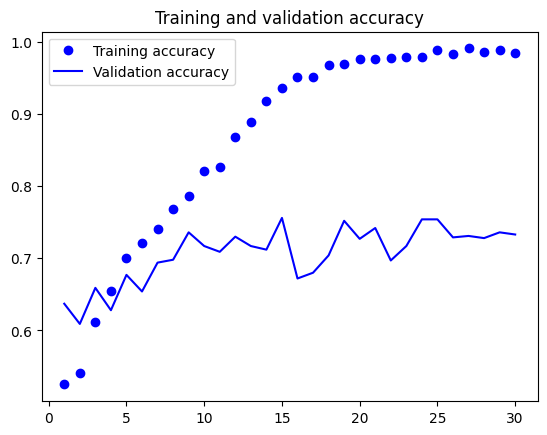

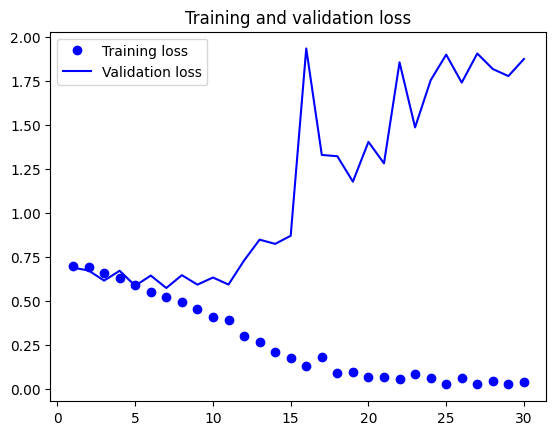

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Lets check the test accuracy , we will reload the model from its saved file to evaluate it as it was before it started overfitting

**Evaluating the model on the test data**

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 35ms/step - loss: 0.5949 - accuracy: 0.7015
Test accuracy: 0.701


**Using data augmentation**

taked the approach of generating more training data from existing training samples by augmenting the samples via a number of random transformation that yield believable - looking images

The gaol is that at training time , your model will never see the exact same picture twice .
In keras , this is done by adding a number of data augmentation layer at the start of your model

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

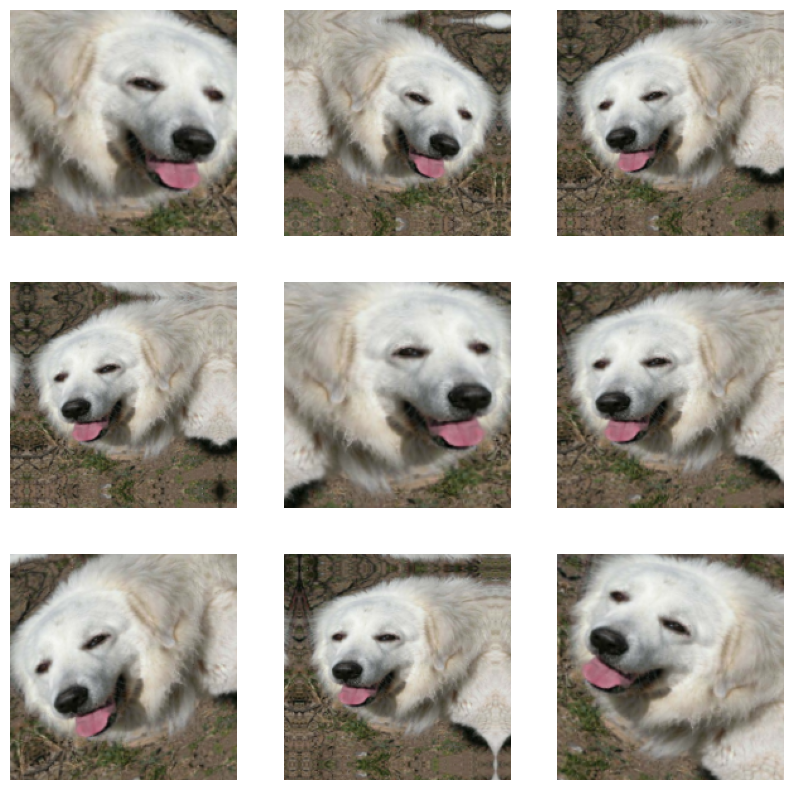

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Define a new convnet that includes images augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 8s 78ms/step - loss: 0.7076 - accuracy: 0.4810 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 4s 66ms/step - loss: 0.6940 - accuracy: 0.5020 - val_loss: 0.6920 - val_accuracy: 0.5030
Epoch 3/100
63/63 [==============================] - 6s 84ms/step - loss: 0.6906 - accuracy: 0.5330 - val_loss: 0.6801 - val_accuracy: 0.5600
Epoch 4/100
63/63 [==============================] - 4s 66ms/step - loss: 0.6773 - accuracy: 0.5910 - val_loss: 0.6880 - val_accuracy: 0.5620
Epoch 5/100
63/63 [==============================] - 4s 65ms/step - loss: 0.6489 - accuracy: 0.6310 - val_loss: 0.6168 - val_accuracy: 0.6510
Epoch 6/100
63/63 [==============================] - 6s 84ms/step - loss: 0.6310 - accuracy: 0.6455 - val_loss: 0.6296 - val_accuracy: 0.6460
Epoch 7/100
63/63 [==============================] - 4s 66ms/step - loss: 0.6162 - accuracy: 0.6580 - val_loss: 0.5977 - val_accuracy: 0.6690
Epoch 

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss , test_acc =  test_model.evaluate(test_dataset)
print(f"test accuarcy : {test_acc:.3f}")

63/63 [==============================] - 2s 33ms/step - loss: 0.4045 - accuracy: 0.8330
test accuarcy : 0.833


**Feature extraction with pretrained model**

Instantiating the VGG16 convolutional base

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Fast feature extraction without data augmentation**

Extracting the VGG16 features and corresponding labels

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 45ms/step


In [ ]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 9ms/step - loss: 15.2997 - accuracy: 0.9250 - val_loss: 3.2463 - val_accuracy: 0.9780
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 4.4206 - accuracy: 0.9740 - val_loss: 8.9112 - val_accuracy: 0.9440
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 2.3446 - accuracy: 0.9835 - val_loss: 7.2030 - val_accuracy: 0.9620
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1.0039 - accuracy: 0.9925 - val_loss: 4.7340 - val_accuracy: 0.9750
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 0.9430 - accuracy: 0.9935 - val_loss: 4.1901 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 1.0563 - accuracy: 0.9900 - val_loss: 3.6680 - val_accuracy: 0.9760
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.2335 - accuracy: 0.9975 - val_loss: 2.7710 - val_accuracy: 0.9860
Epoch 8/20
63/63 [=

**Plotting the results**

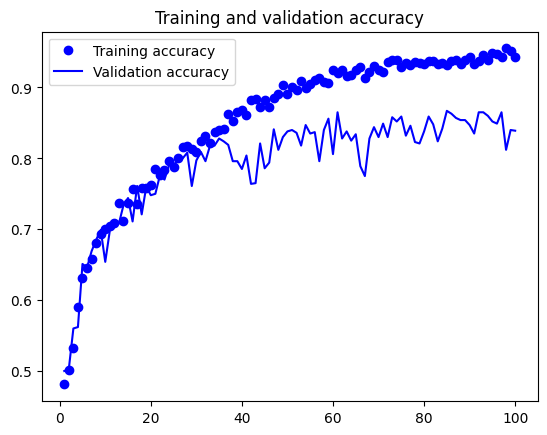

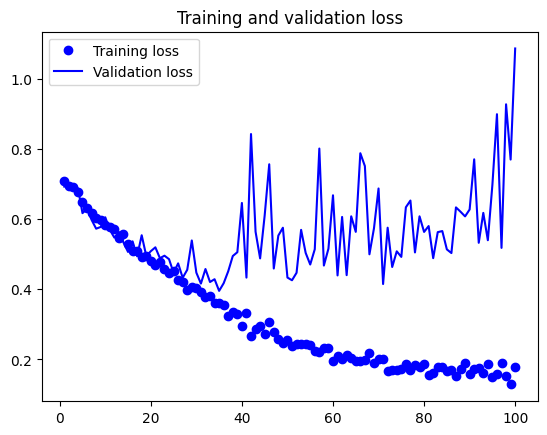

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Feature extraction together with data augmentation**

Instantiating and freezing the VGG16 convolutional base

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 11s 148ms/step - loss: 16.8478 - accuracy: 0.9040 - val_loss: 3.9731 - val_accuracy: 0.9710
Epoch 2/50
63/63 [==============================] - 9s 137ms/step - loss: 7.5312 - accuracy: 0.9405 - val_loss: 4.1586 - val_accuracy: 0.9730
Epoch 3/50
63/63 [==============================] - 9s 138ms/step - loss: 5.6672 - accuracy: 0.9550 - val_loss: 5.2275 - val_accuracy: 0.9700
Epoch 4/50
63/63 [==============================] - 9s 140ms/step - loss: 5.2405 - accuracy: 0.9575 - val_loss: 4.4484 - val_accuracy: 0.9740
Epoch 5/50
63/63 [==============================] - 10s 148ms/step - loss: 4.5531 - accuracy: 0.9655 - val_loss: 4.5819 - val_accuracy: 0.9690
Epoch 6/50
63/63 [==============================] - 9s 144ms/step - loss: 3.9491 - accuracy: 0.9690 - val_loss: 3.6696 - val_accuracy: 0.9790
Epoch 7/50
63/63 [==============================] - 9s 139ms/step - loss: 3.7345 - accuracy: 0.9665 - val_loss: 6.0379 - val_accuracy: 0.9660
Epo

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 94ms/step - loss: 1.9106 - accuracy: 0.9790
Test accuracy: 0.979


**Fine-tuning a pretrained model**

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [ ]:

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 11s 149ms/step - loss: 0.3922 - accuracy: 0.9900 - val_loss: 1.7020 - val_accuracy: 0.9760
Epoch 2/30
63/63 [==============================] - 10s 147ms/step - loss: 0.2684 - accuracy: 0.9925 - val_loss: 1.6807 - val_accuracy: 0.9760
Epoch 3/30
63/63 [==============================] - 11s 178ms/step - loss: 0.3103 - accuracy: 0.9920 - val_loss: 1.6671 - val_accuracy: 0.9770
Epoch 4/30
63/63 [==============================] - 9s 139ms/step - loss: 0.3926 - accuracy: 0.9915 - val_loss: 1.6915 - val_accuracy: 0.9760
Epoch 5/30
63/63 [==============================] - 9s 138ms/step - loss: 0.3110 - accuracy: 0.9915 - val_loss: 1.6957 - val_accuracy: 0.9760
Epoch 6/30
63/63 [==============================] - 9s 140ms/step - loss: 0.2184 - accuracy: 0.9945 - val_loss: 1.6975 - val_accuracy: 0.9760
Epoch 7/30
63/63 [==============================] - 9s 144ms/step - loss: 0.1938 - accuracy: 0.9950 - val_loss: 1.6730 - val_accuracy: 0.9770
Epo

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 88ms/step - loss: 2.3634 - accuracy: 0.9760
Test accuracy: 0.976
